<a href="https://colab.research.google.com/github/Danny2173/RAGproject/blob/main/6_Retriever_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports and Installs

In [ ]:
# Install dependencies
%pip install -q transformers faiss-cpu peft tqdm scikit-learn nltk matplotlib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os, json, re, pickle, itertools
import numpy as np
import pandas as pd
import torch
import faiss
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.stem import PorterStemmer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from transformers import (
    DPRQuestionEncoder,
    DPRQuestionEncoderTokenizer,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DPRContextEncoder,
    DPRContextEncoderTokenizer,
    LogitsProcessor,
    LogitsProcessorList
)
from peft import PeftModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load LoRA adapter weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load tokenizer and LoRA model
tokenizer = AutoTokenizer.from_pretrained("t5-large")
base_model = AutoModelForSeq2SeqLM.from_pretrained("t5-large")
model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/t5-lora-final")
model = model.to(device)


##Loading necessary documents for FAISS Indexing

In [ ]:
with open("/content/drive/MyDrive/corpus_texts.pkl", "rb") as f:
    corpus_texts = pickle.load(f)

with open("/content/drive/MyDrive/normalized_for_index.pkl", "rb") as f:
    normalized_for_index = pickle.load(f)

with open("/content/drive/MyDrive/corpus.pkl", "rb") as f:
    corpus = pickle.load(f)

index = faiss.read_index("/content/drive/MyDrive/faiss_index.index")


##Loading necessary documents for FAISS Indexing

In [ ]:
def count_heading_term_matches(doc_text, matched_main_terms):
    # Normalize text and main terms
    doc_text = doc_text.lower()
    matched_main_terms = set(matched_main_terms)

    # Extracting titles and section headings
    title_match = re.match(r"^(.*?)\n", doc_text)
    title = title_match.group(1) if title_match else ""

    section_matches = re.findall(r"^section:\s*(.*?)$", doc_text, flags=re.MULTILINE)
    subsection_matches = re.findall(r"^subsection:\s*(.*?)$", doc_text, flags=re.MULTILINE)
    subsubsection_matches = re.findall(r"^subsubsection:\s*(.*?)$", doc_text, flags=re.MULTILINE)

    # Combining titles with section headings
    heading_text = " ".join([title] + section_matches + subsection_matches + subsubsection_matches)

    # Tokenize heading text for comparison
    heading_tokens = set(re.findall(r'\b\w[\w\s\-]*\w\b', heading_text))

    # Count matches
    match_count = sum(1 for term in matched_main_terms if term in heading_text)

    return match_count


## Importing Term Normalization functions

In [ ]:
# Importing conversion functions

with open("/content/drive/MyDrive/filtered_term_to_CUI.pkl", "rb") as f:
    term_to_CUI = pickle.load(f)

with open("/content/drive/MyDrive/filtered_cui_to_main_term.pkl", "rb") as f:
    cui_to_main_term = pickle.load(f)

# Creating ngrams and tracking indices
def ngram_tokenize_tokens(tokens, max_len=5):
    ngrams = []
    for i in range(len(tokens)):
        for j in range(i + 1, min(i + 1 + max_len, len(tokens) + 1)):
            span = tokens[i:j]
            ngram = ' '.join(span)
            ngrams.append((ngram, i, j))
    return ngrams

# Normalizing medical terms using main condition name
def cui_normalization(sentence, max_ngram_len=5):
    tokens = re.findall(r'\w+|\W+', sentence)

    # Filtering out words
    words = [w.lower() for w in tokens if re.match(r'\w+', w)]

    # Call tokenization function to return ngrams tuples
    ngrams = ngram_tokenize_tokens(words, max_ngram_len)
    replacements = []

    # Tracking matched CUIs
    matched_cuis = set()

    # Searching for terms in dictionary
    for ngram, start, end in ngrams:
        if ngram in term_to_CUI:
            cui = term_to_CUI[ngram]
            if cui in cui_to_main_term:
                replacements.append((start, end, cui_to_main_term[cui]))
                matched_cuis.add(cui)

    # Sorting by length then index (ensure longer terms first)
    replacements.sort(key=lambda x: (x[0], -(x[1] - x[0])))
    used = set()
    final = []
    # Ensure no overlap (check already used indices)
    for start, end, main_term in replacements:
        if not any(i in used for i in range(start, end)):
            final.append((start, end, main_term))
            used.update(range(start, end))

    # Reconstruct the sentence
    word_idx = 0
    output = []
    i = 0
    while i < len(tokens):
        # If the token is a word
        if re.match(r'\w+', tokens[i]):
            # Checking if index appears in final
            match = next((f for f in final if f[0] == word_idx), None)
            if match:
                output.append(match[2]) # append main term
                skip = match[1] - match[0]
                while skip > 0 and i < len(tokens):
                    if re.match(r'\w+', tokens[i]):
                        skip -= 1
                    i += 1
                # Update word-level index
                word_idx += (match[1] - match[0])
                continue
            word_idx += 1
        output.append(tokens[i])
        i += 1

    normalized_text = ''.join(output)
    matched_main_terms = [term for _, _, term in final]
    return normalized_text, matched_main_terms, list(matched_cuis)


##Building TF-IDF Vectorizer from the corpus

In [ ]:
# Build TF-IDF vectorizer for exact matching
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(normalized_for_index)
tfidf_matrix = normalize(tfidf_matrix)


## Gold Standard dataset

In [ ]:
gold_standard_CE_set = [
    {"query": "Is type 2 diabetes reversible with lifestyle changes?",
     "gold_answer": "Lifestyle changes can sometimes lower your blood glucose to a normal level and stop diabetes (remission).",
     "gold_doc_index": 1509},

    {"query": "Is epilepsy hereditary?",
     "gold_answer": "It's thought that epilepsy is often related to the genes you inherit from your parents, or to changes in your genes.",
     "gold_doc_index": 1832},

    {"query": "What foods should people with celiac disease avoid?",
     "gold_answer": "If you have coeliac disease, you must stop eating all sources of gluten for life.",
     "gold_doc_index": 1096},

    {"query": "When is surgery recommended for gallstones?",
     "gold_answer": "If your symptoms are more severe and frequent, surgery to remove the gallbladder is usually recommended.",
     "gold_doc_index": 2295},

    {"query": "Where in the lungs does tuberculosis primarily affect?",
     "gold_answer": "Tuberculosis (TB) is an infection that usually affects the lungs.",
     "gold_doc_index": 4729},

    {"query": "Where is inflammation seen in Crohn's disease?",
     "gold_answer": "Crohn's disease is a long-term condition where part of your gut becomes inflamed.",
     "gold_doc_index": 1238},

    {"query": "What is the cure for silicosis?",
     "gold_answer": "There's no cure for silicosis because the lung damage can't be reversed.",
     "gold_doc_index": 4476},

    {"query": "How long does an epileptic seizure last?",
     "gold_answer": "A seizure usually lasts a few seconds or minutes, and stops by itself.",
     "gold_doc_index": 1824},

    {"query": "Can I smoke with insomnia?",
     "gold_answer": "do not smoke or drink alcohol, tea or coffee at least 6 hours before going to bed",
     "gold_doc_index": 2656},

    {"query": "Is Scarlet fever contagious?",
     "gold_answer": "Scarlet fever is a contagious infection",
     "gold_doc_index": 4399}
]

gold_standard_OE_set = [
    {"query":"What are the symptoms of liver cancer?",
        "gold_answer": "Symptoms of liver cancer can include the whites of your eyes turning yellow or your skin turning yellow, which may be less obvious on brown or black skin ( jaundice ) - you may also have itchy skin, darker pee and paler poo than usual, loss of appetite or losing weight without trying to, feeling tired or having no energy, feeling generally unwell or having symptoms like flu, a lump in the right side of your tummy",
        "gold_doc_index":2945},
    {"query":"What causes heart failure?",
        "gold_answer": "Conditions that can lead to heart failure include coronary heart disease - where the arteries that supply blood to the heart become clogged up with fatty substances ( atherosclerosis ), which may cause angina or a heart attack, high blood pressure - this can put extra strain on the heart, which over time can lead to heart failure, conditions affecting the heart muscle ( cardiomyopathy ), heart rhythm problems ( arrhythmias ), such as atrial fibrillation, damage or other problems with the heart valves, congenital heart disease - birth defects that affect the normal workings of the heart, and Sometimes obesity, anaemia, drinking too much alcohol, an overactive thyroid or high pressure in the lungs ( pulmonary hypertension ) can also lead to heart failure.",
        "gold_doc_index":2279},
    {"query":"What is the treatment for gum disease?",
        "gold_answer": "In the early stages, your dentist will give you advice about keeping your teeth clean, such as using interdental brushes, advise you to stop smoking, if you smoke, advise you to get your teeth cleaned by a hygienist, If your gum disease is serious, you may need, to have deep cleaning under the gums, antibiotics, to have some teeth removed or gum surgery",
        "gold_doc_index":2148},
    {"query":"What are the early signs of Alzheimer's disease",
        "gold_answer": "The first sign of Alzheimer's disease is usually minor memory problems. For example, this could be forgetting about recent conversations or events, and forgetting the names of places and objects. As the condition develops, memory problems become more severe and further symptoms can develop, such as confusion, disorientation and getting lost in familiar places, difficulty planning or making decisions, problems with speech and language, problems moving around without assistance or performing self-care tasks, personality changes, such as becoming aggressive, demanding and suspicious of others, hallucinations (seeing or hearing things that are not there) and delusions (believing things that are untrue), low mood or anxiety.",
        "gold_doc_index":133},
    {"query":"How can i manage my type 2 diabetes?",
        "gold_answer": "try to eat a healthy diet including fruit, vegetables, wholegrain foods such as wholemeal bread and oats, and pulses such as chickpeas and lentils, improve your diet slowly if you're finding it difficult - a small change every week can make it easier, talk to a GP or diabetes nurse if you're finding it hard to change your diet as they may be able to find support in your local area, try to spend at least 2.5 hours (across the whole week) either walking or doing another activity that leaves you out of breath, try to lose weight if you've been told you're overweight, stop smoking - having diabetes increases the harmful effects of smoking, try to limit how much alcohol you drink, and have regular dental check-ups to help prevent gum disease.",
        "gold_doc_index":1509},
    {"query": "Is motor neurone disease curable?",
        "gold_answer": "It's usually life-shortening and there's currently no cure, but treatment can help manage the symptoms.",
        "gold_doc_index": 3242},
    {"query": "How is malnutrition diagnosed?",
        "gold_answer": "A GP can check if you're at risk of malnutrition by measuring your weight and height, and asking about any medical problems you have or any recent changes in your weight or appetite.",
        "gold_doc_index": 3098},
    {"query": "How can I prevent heart disease?",
        "gold_answer": "You can reduce your risk of getting coronary disease by making some simple lifestyle changes. These include eating a healthy, balanced diet, being physically active, giving up smoking, controlling blood cholesterol and sugar levels, and Keeping your heart healthy",
        "gold_doc_index": 2255},
    {"query": "How can high-risk individuals stay safe from COVID-19?",
        "gold_answer": "If you or your child are at increased risk of getting ill from COVID-19, try to avoid contact with people who have symptoms of COVID-19 until they feel better.",
        "gold_doc_index": 1195},
    {"query": "What is Narcolepsy?",
        "gold_answer": "Narcolepsy is a rare long-term brain condition that can prevent a person from choosing when to wake or sleep.",
        "gold_doc_index": 3386},
    {"query": "What medication should I take for a cold?",
        "gold_answer": "medicines like paracetamol or ibuprofen to ease aches or lower a temperature",
        "gold_doc_index": 1115},
    {"query": "What is the difference between type 1 diabetes and type 2 diabetes?",
        "gold_answer": "Type 2 diabetes is different to type 1 diabetes, which is caused by a problem with your immune system. Unlike type 1 diabetes, type 2 diabetes may be prevented.",
        "gold_doc_index": 1518},
    {"query": "What triggers asthma attacks in children?",
        "gold_answer": "symptoms can be triggered by different things, such as allergies, exercise, smoke, cold air or infections.",
        "gold_doc_index": 392},
    {"query": "What foods help improve iron-deficiency anemia?",
        "gold_answer": "Eat more dark-green leafy vegetables like watercress and curly kale, cereals and bread with extra iron in them (fortified), meat, dried fruit like apricots, prunes and raisins, pulses (beans, peas and lentils)",
        "gold_doc_index": 165},
    {"query": "Is a high temperature a sign of Malaria?",
        "gold_answer": "Malaria can be hard to spot, but symptoms include a high temperature",
        "gold_doc_index": 3077},
    {"query": "What are the warning signs of a stroke?",
        "gold_answer": "Face weakness - one side of your face may droop (fall) and it might be hard to smile, arm weakness - you may not be able to fully lift both arms and keep them there because of weakness or numbness in 1 arm, speech problems - you may slur your words or sound confused, and The easiest way to remember these symptoms is the word FAST.",
        "gold_doc_index": 4662},
    {"query": "What is the surgical procedure to remove cataracts?",
        "gold_answer": "The cloudy lens is replaced with an artificial one.",
        "gold_doc_index": 824},
    {"query": "How is tuberculosis transmitted from person to person?",
        "gold_answer": "When someone with active TB coughs, they release small droplets containing the bacteria. You can catch TB if you regularly breathe in these droplets over a long period of time.",
        "gold_doc_index": 4732},
    {"query": "What should I do if I have problems with my hearing?",
        "gold_answer": "See a GP if you have problems with your hearing.",
        "gold_doc_index": 1298},
    {"query": "How serious are mouth ulcers?",
        "gold_answer": "Mouth ulcers are rarely a sign of anything serious, but may be uncomfortable to live with.",
        "gold_doc_index": 3261}
]

In [ ]:
# Import Query encoder
q_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(device)
q_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

# Logic with and without TF-IDF

def retrieve_indices(query: str, use_tfidf: bool = True, top_k: int = 5):
    # FAISS Dense Retrieval
    inputs = q_tokenizer(query, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        q_emb = q_encoder(**inputs).pooler_output.cpu().numpy()
        q_emb /= np.linalg.norm(q_emb, axis=1, keepdims=True)

    scores, indices = index.search(q_emb, 600)
    faiss_indices = indices[0]
    faiss_scores = scores[0]
    index_scores = {idx: score for idx, score in zip(faiss_indices, faiss_scores)}

    if not use_tfidf:
        # Only FAISS Retrieval
        ranked_indices = sorted(index_scores.items(), key=lambda x: -x[1])
        return [idx for idx, _ in ranked_indices[:top_k]]

    # Boosting Logic (TF-IDF + Heading Matches)
    normalized_query, matched_main_terms, _ = cui_normalization(query)
    heading_matched_indices = [
        i for i, doc_text in enumerate(normalized_for_index)
        if any(term in doc_text.split('.')[0].lower() for term in matched_main_terms)
    ]

    tfidf_query_vec = tfidf_vectorizer.transform([normalized_query])
    tfidf_query_vec = normalize(tfidf_query_vec)
    tfidf_scores = (tfidf_matrix @ tfidf_query_vec.T).toarray().flatten()

    all_indices = set(faiss_indices.tolist()) | set(heading_matched_indices)
    for idx in all_indices:
        if idx not in index_scores:
            index_scores[idx] = 0.1

    boosted_scores = {}
    for idx in all_indices:
        dense_score = index_scores.get(idx, 0.1)
        sparse_score = tfidf_scores[idx]
        heading_matches = count_heading_term_matches(normalized_for_index[idx], matched_main_terms)
        boosted_scores[idx] = 0.9 * dense_score + 0.1 * sparse_score + 0.1 * heading_matches

    ranked_indices = sorted(boosted_scores.items(), key=lambda x: -x[1])
    return [idx for idx, _ in ranked_indices[:top_k]]



Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def evaluate_recall_detailed(gold_set, use_tfidf=True, max_k=10):
    failure_cases = []
    total = len(gold_set)
    hit_counts = [0] * (max_k + 1)  # Recall@1 stored in hit_counts[1]

    for entry in gold_set:
        query = entry["query"]
        gold_doc_index = entry["gold_doc_index"]
        retrieved = retrieve_indices(query, use_tfidf=use_tfidf, top_k=100)  # Search in Top-100 for analysis

        found_at_rank = None
        for rank, idx in enumerate(retrieved, start=1):
            if idx == gold_doc_index:
                found_at_rank = rank
                break

        for K in range(1, max_k + 1):
            if found_at_rank and found_at_rank <= K:
                hit_counts[K] += 1

        if not found_at_rank or found_at_rank > max_k:
            failure_cases.append({
                "query": query,
                "gold_doc_index": gold_doc_index,
                "found_at_rank": found_at_rank
            })

    recall_scores = [hit_counts[K] / total for K in range(1, max_k + 1)]
    return recall_scores, failure_cases


In [ ]:
# FAISS Only
recall_faiss_OE, failures_faiss_OE = evaluate_recall_detailed(gold_standard_OE_set, use_tfidf=False)
recall_faiss_CE, failures_faiss_CE = evaluate_recall_detailed(gold_standard_CE_set, use_tfidf=False)

# Boosted Retrieval (TF-IDF + Title Matching)
recall_boosted_OE, failures_boosted_OE = evaluate_recall_detailed(gold_standard_OE_set, use_tfidf=True)
recall_boosted_CE, failures_boosted_CE = evaluate_recall_detailed(gold_standard_CE_set, use_tfidf=True)

# Recall@K Curves
print("FAISS Recall (OE):", ["Recall@{}: {:.2f}".format(k+1, r) for k, r in enumerate(recall_faiss_OE)])
print("FAISS Recall (CE):", ["Recall@{}: {:.2f}".format(k+1, r) for k, r in enumerate(recall_faiss_CE)])
print("Boosted Retrieval Recall (OE):", ["Recall@{}: {:.2f}".format(k+1, r) for k, r in enumerate(recall_boosted_OE)])
print("Boosted Retrieval Recall (CE):", ["Recall@{}: {:.2f}".format(k+1, r) for k, r in enumerate(recall_boosted_CE)])

# which didn't appear in top-K)
print("Failures FAISS OE:", failures_faiss_OE)
print("Failures FAISS CE:", failures_faiss_CE)
print("Failures Boosted OE:", failures_boosted_OE)
print("Failures Boosted CE:", failures_boosted_CE)


FAISS Recall (OE): ['Recall@1: 0.10', 'Recall@2: 0.25', 'Recall@3: 0.30', 'Recall@4: 0.35', 'Recall@5: 0.40', 'Recall@6: 0.40', 'Recall@7: 0.45', 'Recall@8: 0.55', 'Recall@9: 0.55', 'Recall@10: 0.65']
FAISS Recall (CE): ['Recall@1: 0.30', 'Recall@2: 0.50', 'Recall@3: 0.60', 'Recall@4: 0.70', 'Recall@5: 0.70', 'Recall@6: 0.70', 'Recall@7: 0.70', 'Recall@8: 0.70', 'Recall@9: 0.70', 'Recall@10: 0.70']
Boosted Retrieval Recall (OE): ['Recall@1: 0.20', 'Recall@2: 0.45', 'Recall@3: 0.65', 'Recall@4: 0.70', 'Recall@5: 0.75', 'Recall@6: 0.80', 'Recall@7: 0.80', 'Recall@8: 0.85', 'Recall@9: 0.90', 'Recall@10: 0.95']
Boosted Retrieval Recall (CE): ['Recall@1: 0.50', 'Recall@2: 0.60', 'Recall@3: 0.70', 'Recall@4: 0.70', 'Recall@5: 0.80', 'Recall@6: 0.80', 'Recall@7: 0.80', 'Recall@8: 0.80', 'Recall@9: 0.80', 'Recall@10: 0.80']

Failures - FAISS OE: [{'query': 'How can high-risk individuals stay safe from COVID-19?', 'gold_doc_index': 1195, 'found_at_rank': 49}, {'query': 'What triggers asthma att

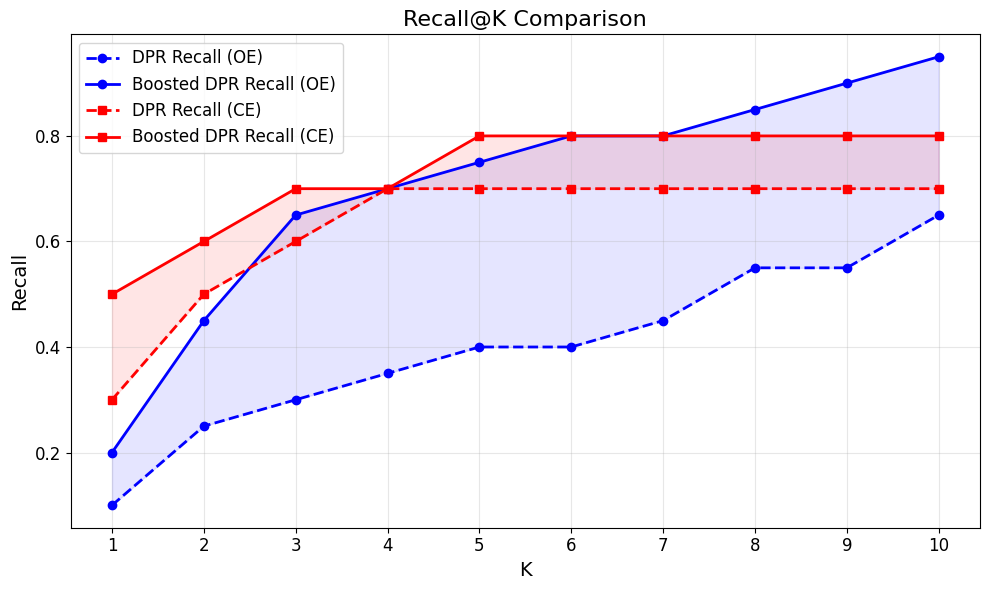

In [ ]:
# Plot Recall Curve

k_values = list(range(1, 11))

plt.figure(figsize=(10, 6))
plt.plot(k_values, recall_faiss_OE, 'b--o', label='DPR Recall (OE)', linewidth=2, markersize=6)
plt.plot(k_values, recall_boosted_OE, 'b-o', label='Boosted DPR Recall (OE)', linewidth=2, markersize=6)
plt.plot(k_values, recall_faiss_CE, 'r--s', label='DPR Recall (CE)', linewidth=2, markersize=6)
plt.plot(k_values, recall_boosted_CE, 'r-s', label='Boosted DPR Recall (CE)', linewidth=2, markersize=6)

plt.fill_between(k_values, recall_faiss_OE, recall_boosted_OE, color='blue', alpha=0.1)
plt.fill_between(k_values, recall_faiss_CE, recall_boosted_CE, color='red', alpha=0.1)


plt.title('Recall@K Comparison', fontsize=16)
plt.xlabel('K', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(k_values, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()